# Spectral Soft Sensor

## 1. Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pca import pca

In [2]:
# Read CSV file -- First column is index/header
df = pd.read_csv("data/Spectral_Soft_Sensor_1.csv", index_col=0)
print(f"Dimensions:")
print(f"Rows = {df.shape[0]} observations")
print(f"Columns = {df.shape[1]} variables")

Dimensions:
Rows = 12180 observations
Columns = 1741 variables


In [3]:
df.head(20)

,Anthocyanin content (μg/cm²),Boron content (mg/cm²),C content (mg/cm²),Ca content (mg/cm²),Carotenoid content (μg/cm²),Cellulose (mg/cm²),Chl content (μg/cm²),Copper content (mg/cm²),EWT (mg/cm²),Fiber (mg/cm²),...,2441,2442,2443,2444,2445,2446,2447,2448,2449,2450
0,NaN,NaN,NaN,0.091526,NaN,NaN,34.047382,NaN,10.889923,NaN,...,0.035515,0.035214,0.034912,0.034611,0.034310,0.034008,0.033707,0.033405,0.033104,0.032803
1,NaN,NaN,NaN,0.038488,NaN,NaN,23.320021,NaN,10.270048,NaN,...,0.047333,0.047102,0.046871,0.046640,0.046409,0.046178,0.045947,0.045716,0.045485,0.045254
2,NaN,NaN,NaN,0.026577,NaN,NaN,27.098073,NaN,11.423791,NaN,...,0.027101,0.026860,0.026619,0.026379,0.026138,0.025897,0.025656,0.025415,0.025174,0.024933
3,NaN,NaN,NaN,0.013190,NaN,NaN,27.638014,NaN,13.132381,NaN,...,0.038942,0.038526,0.038110,0.037694,0.037278,0.036862,0.036446,0.036030,0.035614,0.035198
4,NaN,NaN,NaN,0.082163,NaN,NaN,23.159727,NaN,11.625371,NaN,...,0.049960,0.049475,0.048989,0.048504,0.048019,0.047534,0.047048,0.046563,0.046078,0.045593
5,NaN,NaN,NaN,0.022024,NaN,NaN,20.810395,NaN,10.573226,NaN,...,0.029485,0.028949,0.028413,0.027878,0.027342,0.026807,0.026271,0.025736,0.025200,0.024665
6,NaN,NaN,NaN,0.026577,NaN,NaN,27.098073,NaN,11.423791,NaN,...,0.027101,0.026860,0.026619,0.026379,0.026138,0.025897,0.025656,0.025415,0.025174,0.024933
7,NaN,NaN,NaN,0.099728,NaN,NaN,42.224701,NaN,15.882364,NaN,...,0.016490,0.016190,0.015890,0.015590,0.015290,0.014990,0.014690,0.014390,0.014090,0.013790
8,NaN,NaN,NaN,0.017747,NaN,NaN,26.448420,NaN,7.577363,NaN,...,0.038179,0.037800,0.037421,0.037042,0.036664,0.036285,0.035906,0.035528,0.035149,0.034770
9,NaN,NaN,NaN,0.019997,NaN,NaN,18.708539,NaN,5.814840,NaN,...,0.053531,0.052945,0.052358,0.051772,0.051186,0.050600,0.050014,0.049428,0.048842,0.048256


## 2. Preprocessing and Summary of Data

In [4]:
# Determine where traits end, and bands start
df.columns[19:21] 

Index(['Sulfur content (mg/cm²)', '400'], dtype='object')

In [5]:
df.columns[-1]

'2450'

### 2.1. Splitting Variables as Traits and Bands

In [6]:
# Split variables as traits and bands
traits = df.columns[:20]
bands = df.columns[20:]
# We can conclude that there are;
print(f"Number of Observations: {df.shape[0]}")
print(f"Number of Traits: {len(traits)}")
print(f"Wavelength range: {bands[0]} - {bands[-1]}")# range = wavelength in this dataset

Number of Observations: 12180
Number of Traits: 20
Wavelength range: 400 - 2450


### 2.2. Selecting 5 Traits

In [7]:
# Missing value analysis for traits
traits_null_counts = df[traits].isnull().sum()
traits_null_pct = df[traits].isnull().mean() * 100

trait_missing = pd.DataFrame({
    'Trait': traits,
    'MissingCount': traits_null_counts.values,
    'MissingPercent': traits_null_pct.values.round(2)
}).sort_values(by='MissingCount', ascending=False)

print(trait_missing)

                           Trait  MissingCount  MissingPercent
0   Anthocyanin content (μg/cm²)         11614           95.35
14    Manganese content (mg/cm²)          8833           72.52
18    Potassium content (mg/cm²)          8786           72.13
19       Sulfur content (mg/cm²)          8530           70.03
10                   LAI (m²/m²)          8470           69.54
3            Ca content (mg/cm²)          8465           69.50
1         Boron content (mg/cm²)          8366           68.69
16                  NSC (mg/cm²)          8351           68.56
7        Copper content (mg/cm²)          8316           68.28
13    Magnesium content (mg/cm²)          8263           67.84
17   Phosphorus content (mg/cm²)          8187           67.22
9                 Fiber (mg/cm²)          7983           65.54
5             Cellulose (mg/cm²)          7918           65.01
4    Carotenoid content (μg/cm²)          7916           64.99
12               Lignin (mg/cm²)          7872         

**Note**: Now we need to select 5 traits

In [8]:
top5 = trait_missing.sort_values(by='MissingCount').head(5)
selected_traits = top5['Trait'].tolist()
all_traits = traits 
traits_to_drop = list(set(all_traits) - set(selected_traits))
df = df.drop(columns=traits_to_drop)
traits = selected_traits

In [9]:
print("Remaining traits:")
print(df.columns[:5])

Remaining traits:
Index(['C content (mg/cm²)', 'Chl content (μg/cm²)', 'EWT (mg/cm²)',
       'LMA (g/m²)', 'N content (mg/cm²)'],
      dtype='object')


Note: These are the selected traits(Why? We choose 5 traits with least amount of missing values)

### 2.3. Checking Empty Spectral Bands 

In [10]:
# Check how many spectral bands are completely empty
bands_null_counts = df[bands].isnull().sum()
fully_missing_bands = (bands_null_counts == df.shape[0]).sum()
print(f"Number of completely missing bands: {fully_missing_bands}")

Number of completely missing bands: 0


**Note:** There are no missing bands

### 2.4. Visuals for Traits

In [11]:
# Summary for traits
trait_stats = df[traits].describe().T 
trait_stats = trait_stats.round(4)

trait_summary = trait_stats[["mean", "std", "min", "50%", "max"]]
trait_summary.rename(columns={"50%": "median"}, inplace=True)

print(trait_summary.head())

                          mean      std     min   median       max
LMA (g/m²)            108.5145  79.7602  5.7191  84.5500  663.8073
N content (mg/cm²)      0.2091   0.1008  0.0069   0.1976    0.8762
C content (mg/cm²)      6.6800   4.9217  0.1028   4.7997   37.2915
Chl content (μg/cm²)   42.3512  13.7288  4.4483  42.5941   98.3887
EWT (mg/cm²)           16.2212  10.4858  0.2268  12.1548   80.6201


/var/folders/_q/9bb35y7928b8cwm8khhrd7900000gn/T/ipykernel_27138/1655883163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trait_summary.rename(columns={"50%": "median"}, inplace=True)


In [12]:
# For some traits, standard devaiations are high - must be considered in reporting part

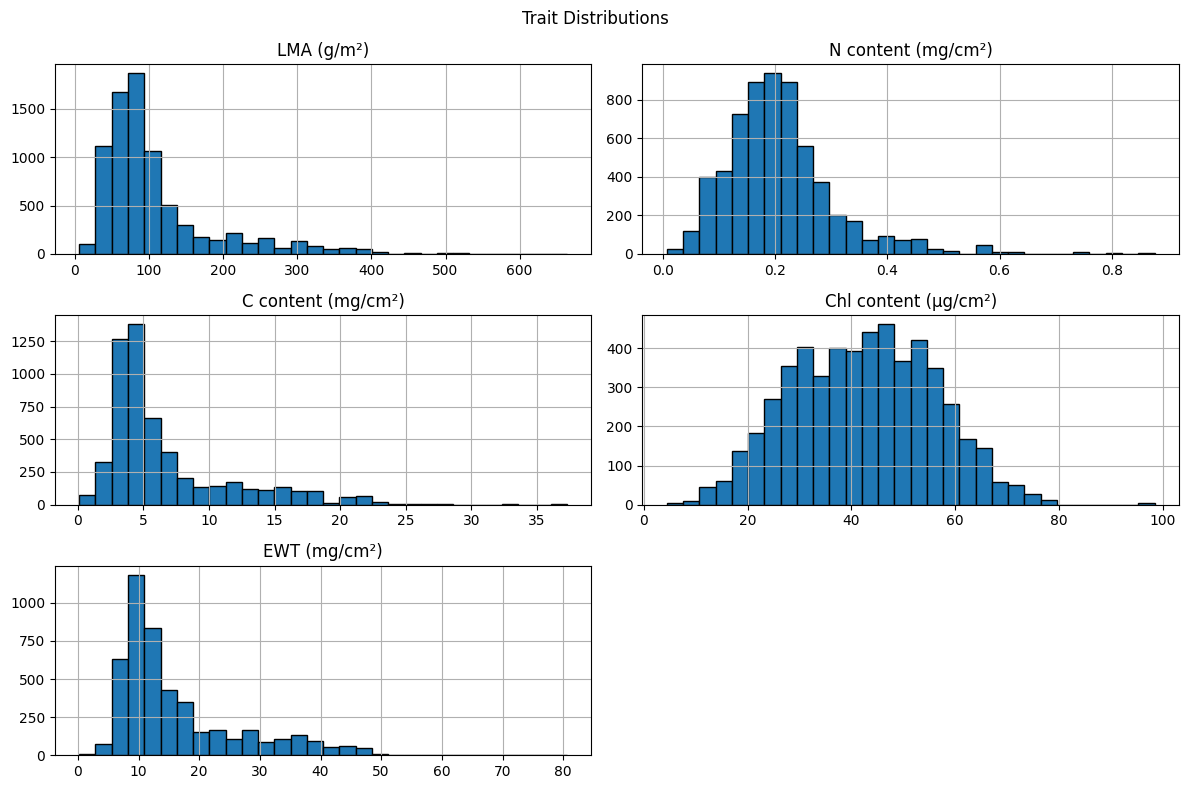

In [13]:
# Histograms for traits
df[traits].hist(figsize=(12,8), bins=30, edgecolor='black')
plt.suptitle('Trait Distributions')
plt.tight_layout()
plt.show()

### 2.5. Visualizing Wavelengths

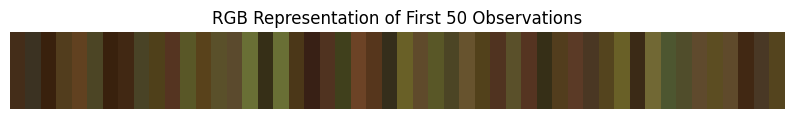

In [14]:
# Converting wavelengths to RGB, then visualize
wavelengths = bands.astype(int) # from '450' => 450

spectral_data = df[bands].values

# RGB range
def to_rgb(wmin, wmax): # RGB range
    return (wavelengths >= wmin) & (wavelengths <= wmax)

range_red = to_rgb(625, 740)  # https://en.wikipedia.org/wiki/Green
range_green = to_rgb(495, 570)# https://en.wikipedia.org/wiki/Green
range_blue = to_rgb(450, 495) # https://en.wikipedia.org/wiki/Blue

# Findind the RGB matrix
rgb_data = np.stack([
    np.nanmean(spectral_data[:, range_red], axis=1),
    np.nanmean(spectral_data[:, range_green], axis=1),
    np.nanmean(spectral_data[:, range_blue], axis=1)
], axis=1)

# Min-max normalization (0-1)
rgb_normalized = np.zeros_like(rgb_data)
for i in range(3):  # R, G, B
    channel = rgb_data[:, i]
    rgb_normalized[:, i] = (channel - np.nanmin(channel)) / (np.nanmax(channel) - np.nanmin(channel))

# Visualization for the first 50 Observations
plt.figure(figsize=(10, 1))
plt.imshow([rgb_normalized[0:50]], aspect='auto')
plt.title("RGB Representation of First 50 Observations")
plt.axis('off')
plt.show()

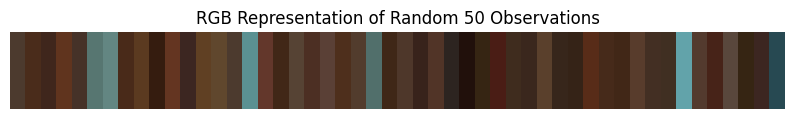

In [15]:
plt.figure(figsize=(10, 1))
plt.imshow([rgb_normalized[1300:1350]], aspect='auto')
plt.title("RGB Representation of Random 50 Observations")
plt.axis('off')
plt.show()

## 3. PCA

### 3.1. Standardization

In [16]:
# Separating traits and bands dataframes
traits_df = df[traits].copy()
bands_df = df[bands].copy()

In [17]:
wavelengths = [int(i) for i in bands_df.columns.to_list()]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(bands_df)

print("Data standardized successfully")
print(f"Mean after scaling: {X_scaled.mean():.6f}")
print(f"Std after scaling: {X_scaled.std():.6f}")

Data standardized successfully
Mean after scaling: 0.000000
Std after scaling: 1.000000


### 3.2. Correlation Matrix

In [18]:
# Calculate correlation matrix (sample a subset for visualization if too large)
corr_matrix = bands_df.corr()
print("Correlation matrix calculated for all wavelengths")

Correlation matrix calculated for all wavelengths


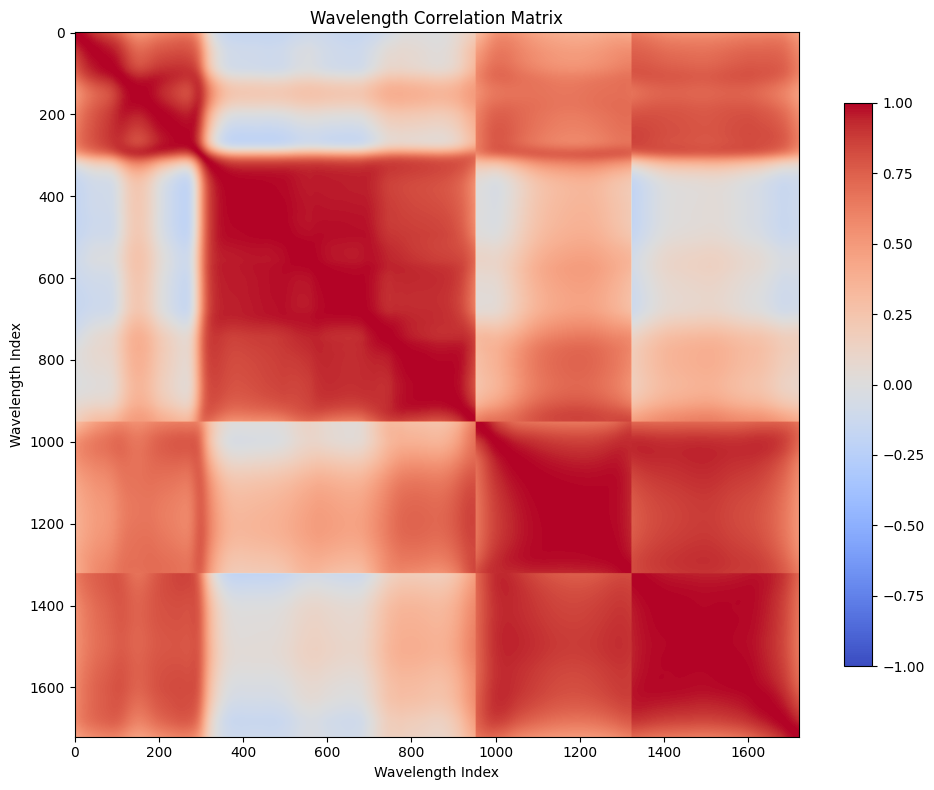

In [19]:
fig = plt.figure(figsize=(10, 8))
ax3 = plt.plot(1, 3, 3)
im = plt.imshow(corr_matrix.values, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.title('Wavelength Correlation Matrix')
plt.xlabel('Wavelength Index')
plt.ylabel('Wavelength Index')
plt.colorbar(im, shrink=0.8)

plt.tight_layout()
plt.savefig("Figure1.png", dpi=300)  
plt.show()

In [20]:
model = pca(normalize=False, n_components=10)
# Fit transform and include the column labels and row labels
results = model.fit_transform(X_scaled, col_labels=wavelengths)

[20-09-2025 19:56:10] [pca.pca] [INFO] Row labels are auto-completed.
[20-09-2025 19:56:10] [pca.pca] [INFO] The PCA reduction is performed on the 1721 columns of the input dataframe.
[20-09-2025 19:56:10] [pca.pca] [INFO] Fit using PCA.
[20-09-2025 19:56:11] [pca.pca] [INFO] Compute loadings and PCs.
[20-09-2025 19:56:11] [pca.pca] [INFO] Compute explained variance.
[20-09-2025 19:56:11] [pca.pca] [INFO] Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[10]
[20-09-2025 19:56:12] [pca.pca] [INFO] Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[20-09-2025 19:56:12] [pca.pca] [INFO] Outlier detection using SPE/DmodX with n_std=[3]


### 3.3. PCA Explained Variance Ratio

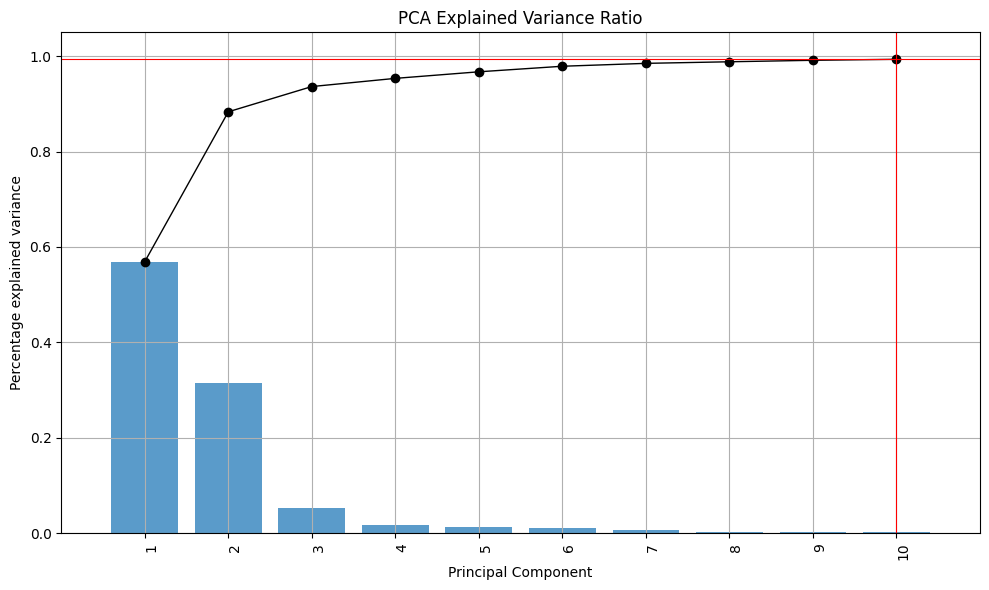

In [21]:
# Make plot
fig, ax = model.plot(figsize=(10,6), title="PCA Explained Variance Ratio")
plt.tight_layout()
plt.savefig("Figure2.png", dpi=300)  
plt.show()

### 3.4. PCA Biplot with Loadings

[20-09-2025 19:56:13] [pca.pca] [INFO] Plot PC1 vs PC2 with loadings.
[20-09-2025 19:56:13] [scatterd.scatterd] [INFO] Create scatterplot


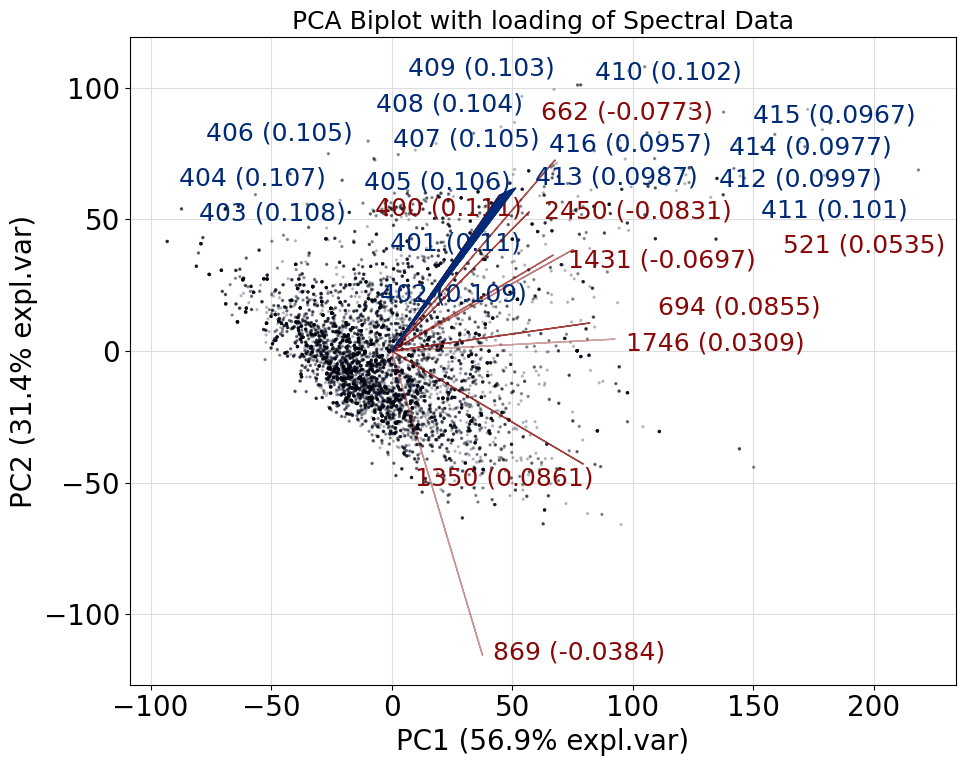

In [22]:
model.biplot(figsize=(10,8), legend=False, alpha=0.2, marker='o', s=2, title="PCA Biplot with loading of Spectral Data")
results['topfeat']
plt.tight_layout()
plt.savefig("Figure3.png", dpi=300)  
plt.show()

### 3.5. PC1 and PC2 Loadings

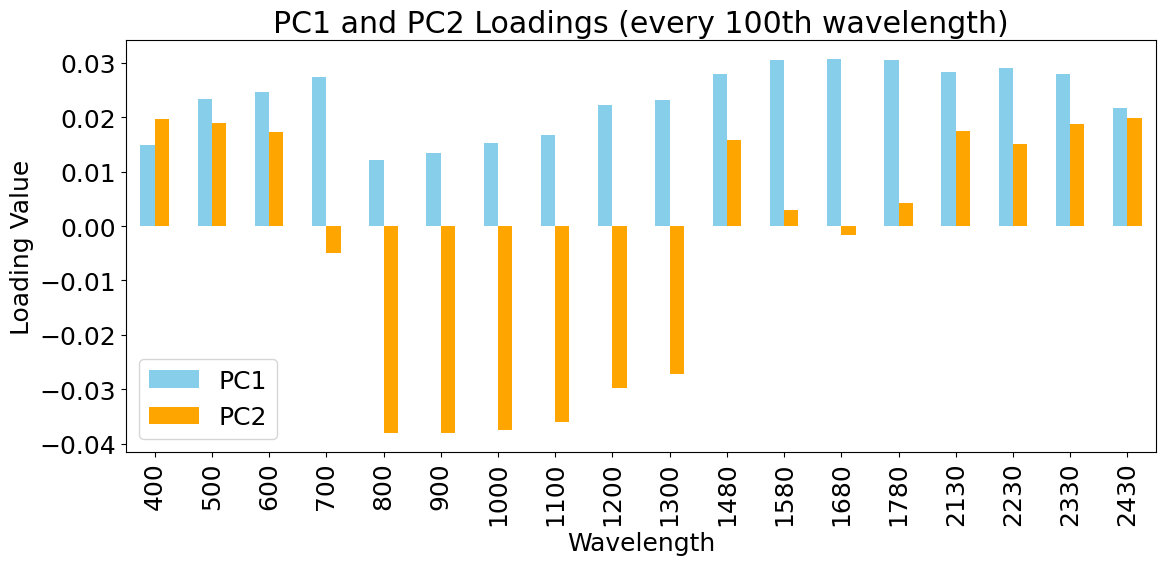

In [23]:
# Example: plot loadings for PC1
pc1_loadings = results['loadings'].loc["PC1"][::100]
pc2_loadings = results['loadings'].loc["PC2"][::100]

# Combine into a single DataFrame 
df_plot = pd.DataFrame({
    "PC1": pc1_loadings,
    "PC2": pc2_loadings
}, index=pc1_loadings.index)  # use wavelength as index

# Plot
df_plot.plot(kind="bar", figsize=(12,6), color=["skyblue", "orange"])
plt.title("PC1 and PC2 Loadings (every 100th wavelength)")
plt.xlabel("Wavelength")
plt.ylabel("Loading Value")

plt.tight_layout()
plt.savefig("Figure4.png", dpi=300)  
plt.show()


### 3.6. Most Influential Wavelengths

In [24]:
# Find wavelengths with highest loadings for each PC
def analyze_pc_loadings(i, n_top):   
    loadings = results['loadings'].loc[f"PC{i}"].abs().sort_values(ascending=False).head(n_top)
    print(f"\nPC{i} - Top {n_top} influential wavelengths:")
    print("-" * 40)
    for k, v in loadings.items():
        print(f"{i+1:2d}. {k:6.1f}nm: {v:8.4f}")

# Analyze first 2 PCs
for pc in range(2):
    analyze_pc_loadings(pc+1, 5)

# Variable correlation summary
print(f"\n" + "="*50)
print("CORRELATION SUMMARY")
print("="*50)

# Calculate average correlation between adjacent wavelengths
adj_correlations = []
for i in range(len(bands_df.columns)-1):
    corr = bands_df.iloc[:, i].corr(bands_df.iloc[:, i+1])
    adj_correlations.append(corr)

print(f"Average correlation between adjacent wavelengths: {np.mean(adj_correlations):.4f}")
print(f"Minimum correlation between adjacent wavelengths: {np.min(adj_correlations):.4f}")
print(f"Maximum correlation between adjacent wavelengths: {np.max(adj_correlations):.4f}")

print(f"\n" + "="*50)
# Summary statistics
print("PCA SUMMARY")
print("="*50)

print(f"Original dimensions: {bands_df.shape}")
print(f"Total variance explained by first 2 PCs: {results['explained_var'][1]:.4f}")
print(f"Total variance explained by first 3 PCs: {results['explained_var'][2]:.4f}")
print(f"Total variance explained by first 5 PCs: {results['explained_var'][4].sum():.4f}")


PC1 - Top 5 influential wavelengths:
----------------------------------------
 2. 1746.0nm:   0.0309
 2. 1747.0nm:   0.0309
 2. 1745.0nm:   0.0309
 2. 1748.0nm:   0.0309
 2. 1744.0nm:   0.0309

PC2 - Top 5 influential wavelengths:
----------------------------------------
 3.  869.0nm:   0.0384
 3.  870.0nm:   0.0384
 3.  868.0nm:   0.0384
 3.  871.0nm:   0.0384
 3.  867.0nm:   0.0384

CORRELATION SUMMARY
Average correlation between adjacent wavelengths: 0.9996
Minimum correlation between adjacent wavelengths: 0.6180
Maximum correlation between adjacent wavelengths: 1.0000

PCA SUMMARY
Original dimensions: (12180, 1721)
Total variance explained by first 2 PCs: 0.8834
Total variance explained by first 3 PCs: 0.9363
Total variance explained by first 5 PCs: 0.9673
